#Step 1: Importing relevant libraries and packages

In [2]:
!pip install keras-tuner -q
import keras_tuner

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
#from kerastuners.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 12.2 MB/s eta 0:00:00


#Step 2: Load the CIFAR10 dataset and quick visualize

In [3]:
(train_images, train_labels),(test_images,test_labels) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


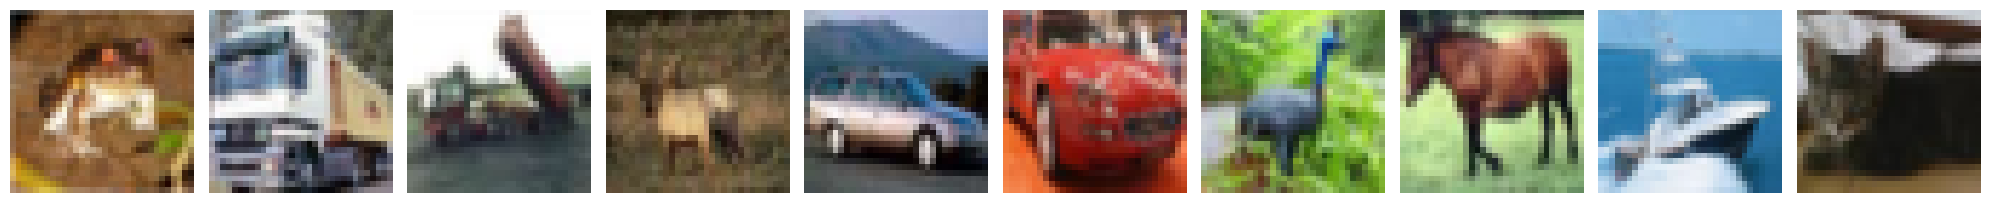

In [4]:
#Define a function to display 10 images from the train set
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(train_images[:10])

In [5]:
#Taking a look at the shape of train and test datasets
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

#Step 3: Preprocess the data

In [6]:
#Reducing the images pixel size to range between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

#Step 4: Define the CNN model function that takes hyperparameters as input

In [7]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


#Step 5: Reading the model summary

In [8]:

# Initialize the `HyperParameters` and set the values.
hp = keras_tuner.HyperParameters()
hp.values["model_type"] = "cnn"
# Build the model using the `HyperParameters`.
model = build_model(hp)
# Test if the model runs with our data.
model(train_images[:100])
# Print a summary of the model.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1

#Step 6: Define the tuner and start the hyperparameter search

In [9]:

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='cifar10_tuner',
    project_name='cifar10_hyperparam'
)

tuner.search(train_images, train_labels, epochs=10, validation_split=0.1)


Trial 5 Complete [00h 02m 24s]
val_accuracy: 0.6331999897956848

Best val_accuracy So Far: 0.6488000154495239
Total elapsed time: 00h 10m 07s


#Step 7: Print the best hyperparameters and retrain the model using those hyperparameters

In [10]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f'Best Hyperparameters: {best_hyperparameters}')

best_model.fit(train_images, train_labels, epochs=10, validation_split=0.1)


Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fae043e4400>
Epoch 1/10
1407/1407 [==============================] - 13s 8ms/step - loss: 0.1085 - accuracy: 0.9693 - val_loss: 1.4226 - val_accuracy: 0.6376
Epoch 2/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0934 - accuracy: 0.9716 - val_loss: 1.7779 - val_accuracy: 0.6272
Epoch 3/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0777 - accuracy: 0.9763 - val_loss: 2.3451 - val_accuracy: 0.6016
Epoch 4/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0652 - accuracy: 0.9797 - val_loss: 1.7414 - val_accuracy: 0.6412
Epoch 5/10
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0505 - accuracy: 0.9841 - val_loss: 2.0231 - val_accuracy: 0.6252
Epoch 6/10
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0521 - accuracy: 0.9832 - val_loss: 1.9610 - val_accuracy: 0.6300
Epoch 7/10
140